In [1]:
from aiutils import *

import os
os.environ['GIT_PYTHON_REFRESH']='quiet' # So that mlflow does not WARN when lacking git

import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    median_absolute_error,
    r2_score
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.
  


### Data is loaded

* Some transformations of maturity month and year as well ad the date of the operation are made.
* These transformations consist in sin, cos, x_powerd(p). All of them normalized between 0 and 1.

In [2]:
df = add_features(read_data(), extra_feats=True)

In [3]:
def simple_network_train_and_report(
    X, y,
    max_iter: int = 500, 
    random_state: int = 123,
    hidden_layer_sizes: List[int] = [1000],
    params: dict = {},
):
    """
    This is a simple NN that trains and reports metrics for both Training and Testing partition.
    The lost is squared error
    
    Args:
    
        X: features
        y: algo
        max_iter: maximum number of interations if patiance condition is not met
        random_state: the random seed
        hidden_layer_sizes: This are the hidden layers of the NN
        params: Other params to log in mlflow
    
    Returns:
    
        Tuple with dataframe results and the sklearn object to measure metrics and stuff
    """
    import warnings
    from sklearn.exceptions import DataConversionWarning
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)

    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=random_state)

    regr = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        activation='relu',
        solver='adam',
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.01,
        max_iter=max_iter,
        shuffle=True,
        random_state = random_state,
        tol=0.0001,
        verbose=False,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    ).fit(X_train, y_train)

    # Display Results

    results = pd.DataFrame(data={
        'partition':['train','test'],
        'mean_abs_err':[mean_absolute_error(y_train,regr.predict(X_train)),mean_absolute_error(y_test,regr.predict(X_test))],
        'mean_sqrt_err':[mean_squared_error(y_train,regr.predict(X_train)),mean_squared_error(y_test,regr.predict(X_test))],
        'median_abs_err':[median_absolute_error(y_train,regr.predict(X_train)),median_absolute_error(y_test,regr.predict(X_test))],
        'R2':[r2_score(y_train,regr.predict(X_train)),r2_score(y_test,regr.predict(X_test))]
    })
    
    with mlflow.start_run() as run:
        
        mlflow.log_param('hiddenLayers', ','.join([str(h) for h in hidden_layer_sizes]))
        mlflow.log_param("RandomState", random_state)
        mlflow.log_param("earlyStop", 'True')
        mlflow.log_param('Loss', regr.loss)

        for k in params:
            mlflow.log_param(k, params[k])

        d = results.to_dict()
        p = d.pop('partition')

        for k in d:
            for i in (0,1):
                mlflow.log_metric(f"{k}P{p[i]}", d[k][i])
        
        for step in range(len(regr.loss_curve_)):
            
            mlflow.log_metric('LossCurve', regr.loss_curve_[step], step)
            mlflow.log_metric('ValiScores', regr.validation_scores_[step], step)
    
    return results, regr

Here we will input:
* Portion of the year as day_of_the_year/365 when the oparation was set
* Portion of the year as month_of_the_year_0_indexed/11 when the contract expires
* Expiry year normalized as (y-earliest)/(latest-earliest)
* if it is corn=1, soya=0
* Filter by observation type Settle

^^^run mlflow to check results^^^

# Single model for Soya & Corn for "Settle" operations

In [27]:
class Predictor:

    def __init__(self, feats, df_train):
        self.feats = feats
        self.hidden_layer_sizes = [1000, 500,  200, 100, 50]
        self.df_train = df_train
        _ = self.train()
        
    def train(self):
        """Train"""
        results, regr = simple_network_train_and_report(
            X = self.df_train[self.feats],
            y = self.df_train['value'],
            hidden_layer_sizes=self.hidden_layer_sizes,
            max_iter = 1000,
            random_state = 123,
            params = {}
        )
        self.results = results
        self.regr = regr

    def add_pred(self, df_pred):
        """
        Args:
            df_pred. Dataframe with samples to predict from
        
        Returns:
            df_pred. Dataframe with pred column in it
        """

        pred = regr.predict(df_pred[self.feats])

        df_pred['pred'] = [p for p in pred]

        return df_pred

In [28]:
p = Predictor(
    df_train = df[df['observation']=='Settle'],
    feats = [
        #'Ndays', 'Nmatmonth', 'Nmatyear',
        'iscorn',
        'NdaysS', 'NmatmonthS',
        'NdaysC', 'NmatmonthC'
    ] + \
    [ f'Ndays{p}' for p in range(10) ] + \
    [ f'Nmatmonth{p}' for p in range(10) ] + \
    [ f'Nmatyear{p}' for p in range(10) ]
)

## Predict with same sampling of orignal data

In [29]:
df_plot = p.add_pred(df[df['observation']=='Settle'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No handles with labels found to put in legend.


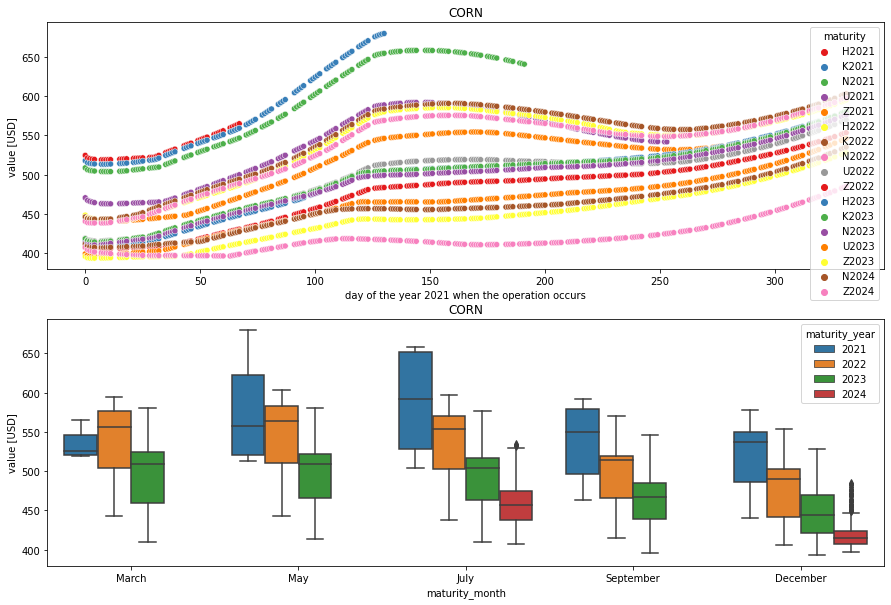

In [30]:
plot_prediciton(df_plot, kind='CBOT.ZC')

No handles with labels found to put in legend.


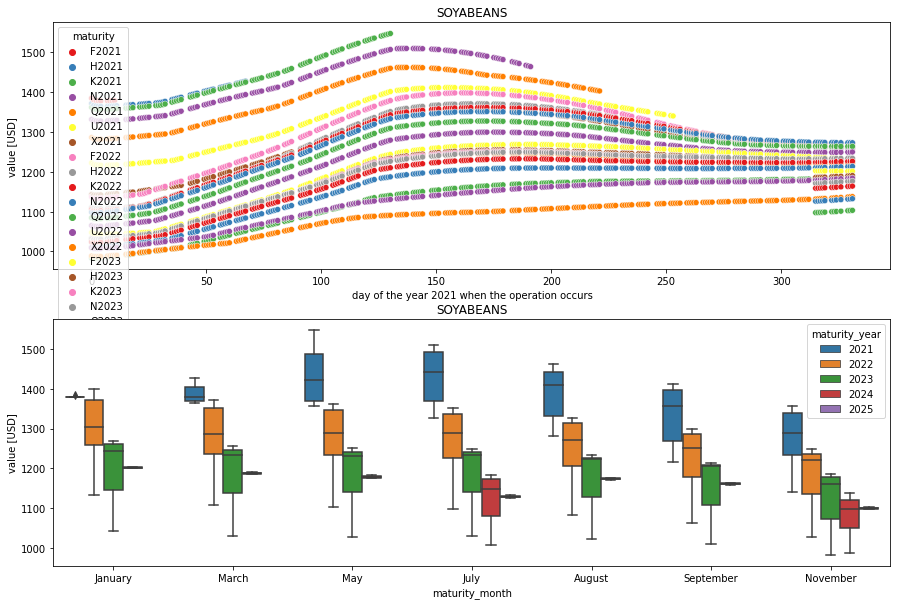

In [31]:
plot_prediciton(df_plot, kind = 'CBOT.ZS')

### We overlap prediction against grountruth data

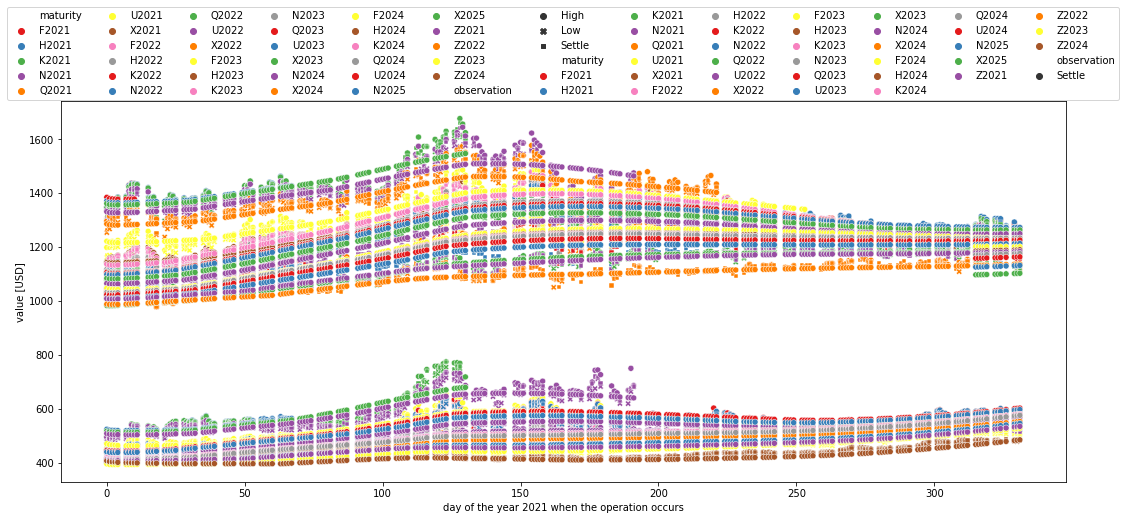

In [7]:
fig, ax = plt.subplots(1, 1,figsize=(18,7))

handler = sns.scatterplot(
    data=df, x="days", y="value", hue="maturity", style="observation", legend='full',
    palette = sns.color_palette("Set1", 34) # It is important that the colors are random here
)

handler = sns.scatterplot(
    data=df_plot, x="days", y="pred", hue="maturity", style="observation", legend='full',
    palette = sns.color_palette("Set1", 34) # It is important that the colors are random here
)

ax.set_ylabel('value [USD]')
ax.set_xlabel('day of the year 2021 when the operation occurs')

plt.legend(ncol=13, bbox_to_anchor=(0.5, 0.99), loc="lower center")

## Predict a by quering regular sampling

* For now, we decide to query the 15th for each month

In [45]:
supervect = []

for date in [f'2021-{m:02d}-15T00:00:00.000Z' for m in range(1,13)]:
    for observation in ['High', 'Low', 'Settle']:
        for maturity in df['maturity'].unique():
            for instrument in ['CBOT.ZS', 'CBOT.ZC']:
                
                supervect.append([date,observation,maturity,instrument])
                
dfquery = pd.DataFrame({
    'date': [s[0] for s in supervect],
    'observation': [s[1] for s in supervect],
    'maturity': [s[2] for s in supervect],
    'instrument': [s[3] for s in supervect],
})

dfquery = add_features(dfquery, extra_feats=True)

In [47]:
df_plot = p.add_pred(dfquery[dfquery['observation']=='Settle'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No handles with labels found to put in legend.


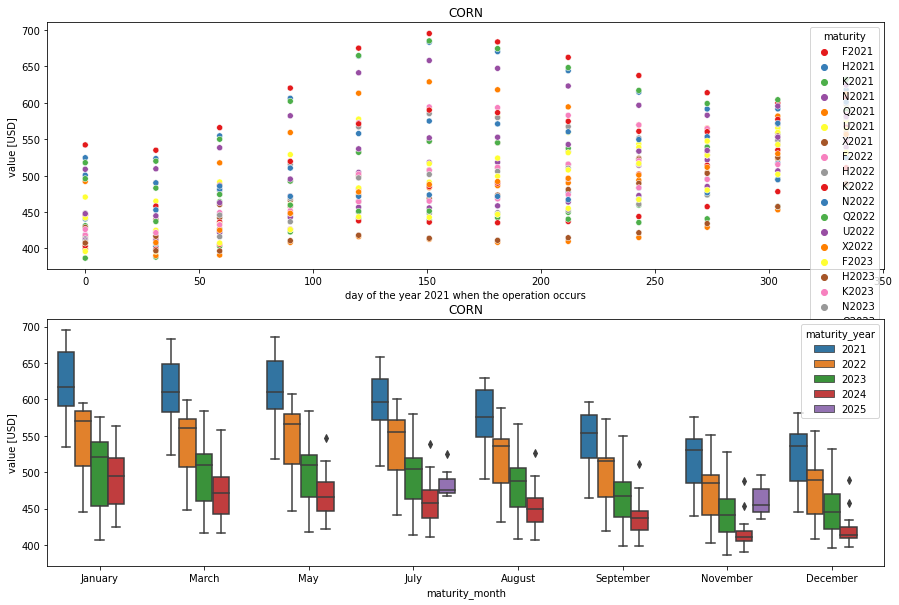

In [48]:
plot_prediciton(df_plot, kind='CBOT.ZC')

No handles with labels found to put in legend.


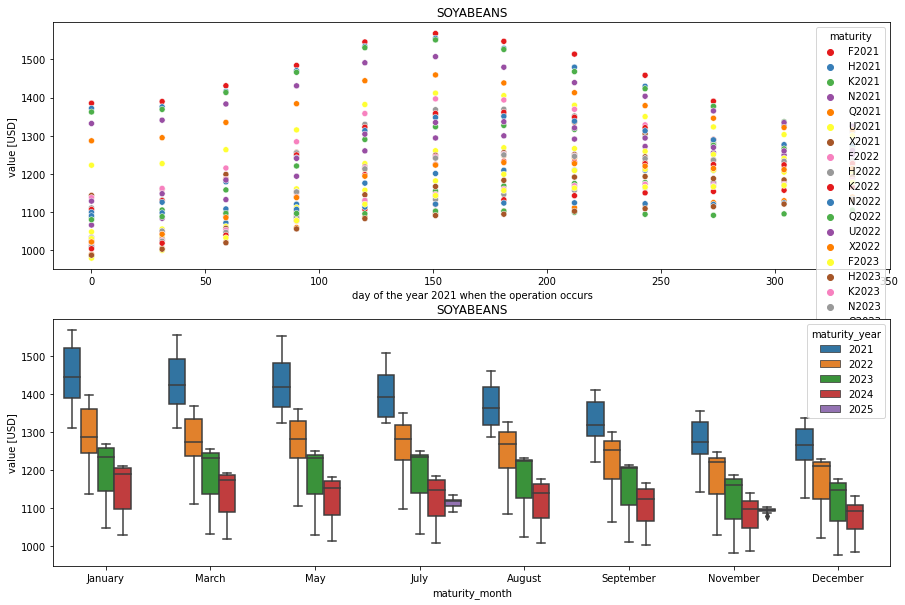

In [49]:
plot_prediciton(df_plot, kind='CBOT.ZS')

## Baseline prediction for 2022 with regular steps query

Now if we shift the years so that the prediction is for 2022...

In [74]:
df_summary = df_plot[['days', 'maturity_month', 'maturity_year', 'date', 'instrument', 'maturity', 'pred']]

# maturity for prediction of 2022
df_summary['maturity'] = [code[0]+str(int(code[1::])+1) for code in df_summary['maturity']]
df_summary['maturity_year'] = [ my+1 for my in df_summary['maturity_year'] ]

# The prediction is for dates in 2022
df_summary['date'] = [d[:3]+'2'+d[4:] for d in df_summary['date']]

df_summary

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,days,maturity_month,maturity_year,date,instrument,maturity,pred
136,0,January,2022,2022-01-15T00:00:00.000Z,CBOT.ZS,F2022,1385.096917
137,0,January,2022,2022-01-15T00:00:00.000Z,CBOT.ZC,F2022,542.171661
138,0,March,2022,2022-01-15T00:00:00.000Z,CBOT.ZS,H2022,1371.679945
139,0,March,2022,2022-01-15T00:00:00.000Z,CBOT.ZC,H2022,524.535359
140,0,May,2022,2022-01-15T00:00:00.000Z,CBOT.ZS,K2022,1362.042965
...,...,...,...,...,...,...,...
2443,334,December,2023,2022-12-15T00:00:00.000Z,CBOT.ZC,Z2023,556.519850
2444,334,December,2024,2022-12-15T00:00:00.000Z,CBOT.ZS,Z2024,1177.711552
2445,334,December,2024,2022-12-15T00:00:00.000Z,CBOT.ZC,Z2024,531.859456
2446,334,December,2025,2022-12-15T00:00:00.000Z,CBOT.ZS,Z2025,1131.475165


No handles with labels found to put in legend.


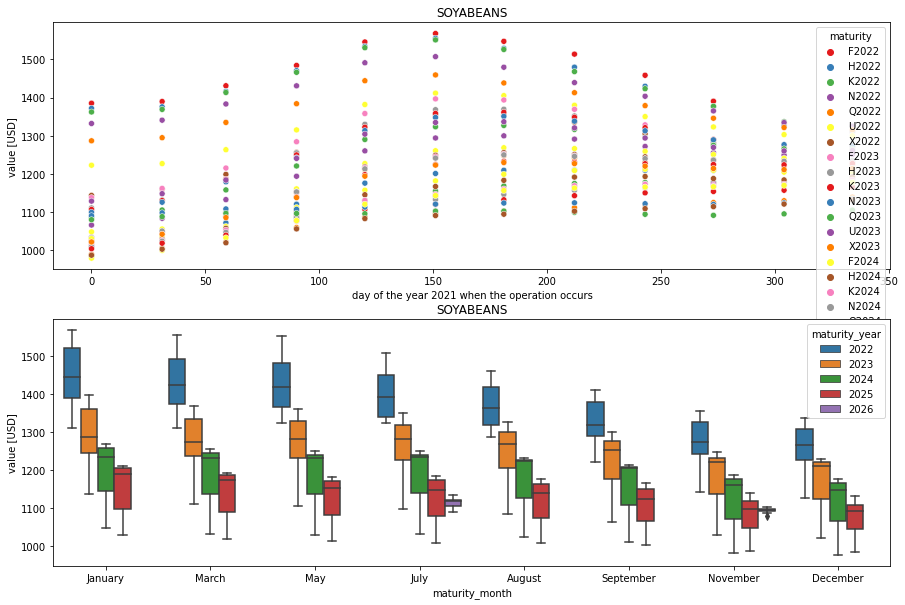

In [75]:
plot_prediciton(df_summary, kind='CBOT.ZS')

No handles with labels found to put in legend.


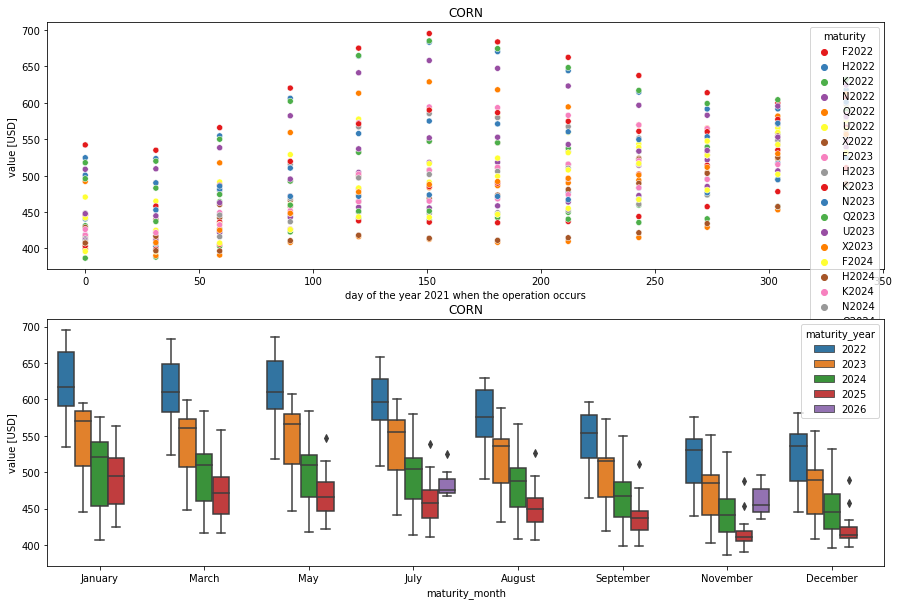

In [76]:
plot_prediciton(df_summary, kind='CBOT.ZC')

In [66]:
dfsum1 = df_summary[df_summary['instrument']=='CBOT.ZC'].pivot(index='maturity', columns='date', values='pred')
dfsum1

date,2022-01-15T00:00:00.000Z,2022-02-15T00:00:00.000Z,2022-03-15T00:00:00.000Z,2022-04-15T00:00:00.000Z,2022-05-15T00:00:00.000Z,2022-06-15T00:00:00.000Z,2022-07-15T00:00:00.000Z,2022-08-15T00:00:00.000Z,2022-09-15T00:00:00.000Z,2022-10-15T00:00:00.000Z,2022-11-15T00:00:00.000Z,2022-12-15T00:00:00.000Z
maturity,,,,,,,,,,,,
F2022,542.171661,534.876363,565.900072,620.240266,675.092741,695.159501,683.650439,662.413983,637.466924,613.863715,599.770663,612.284715
F2023,445.270000,444.561585,474.724540,519.293172,572.599082,594.340366,593.386869,582.805987,569.629661,564.508496,572.185046,586.566418
F2024,414.952364,407.453716,432.195237,460.419118,501.064671,516.339004,524.113323,531.516808,538.776371,547.542728,559.353965,575.178845
F2025,442.239195,424.809357,433.207948,460.019452,483.045844,491.100993,499.124226,507.779057,516.712818,528.131643,542.610848,562.904754
H2022,524.535359,523.379147,554.640276,606.231414,664.173967,683.189173,670.317102,644.150230,614.643399,591.554215,591.659835,618.134855
H2023,448.486311,452.997572,479.268407,515.460337,566.981326,585.200593,579.619488,567.325383,551.635502,553.152750,570.530391,598.548515
H2024,416.125433,417.563350,442.124976,466.049716,499.985228,507.663829,510.646990,515.374285,522.267616,533.795342,554.532485,583.795738
H2025,428.868794,416.760821,426.758126,447.935964,464.229568,468.524047,473.291924,480.911618,489.309049,503.192622,525.103772,558.151874
K2022,517.793443,519.854766,549.980786,602.147116,664.838921,685.041861,674.459956,648.386601,616.980504,599.020572,604.200096,631.968756


In [67]:
dfsum2 = df_summary[df_summary['instrument']=='CBOT.ZS'].pivot(index='maturity', columns='date', values='pred')
dfsum2

date,2022-01-15T00:00:00.000Z,2022-02-15T00:00:00.000Z,2022-03-15T00:00:00.000Z,2022-04-15T00:00:00.000Z,2022-05-15T00:00:00.000Z,2022-06-15T00:00:00.000Z,2022-07-15T00:00:00.000Z,2022-08-15T00:00:00.000Z,2022-09-15T00:00:00.000Z,2022-10-15T00:00:00.000Z,2022-11-15T00:00:00.000Z,2022-12-15T00:00:00.000Z
maturity,,,,,,,,,,,,
F2022,1385.096917,1389.522729,1430.911629,1484.222714,1545.763725,1567.951000,1547.440368,1513.887570,1458.369668,1390.345058,1330.951866,1309.656018
F2023,1137.124461,1161.406865,1214.986774,1283.927469,1358.012204,1396.435397,1393.509565,1369.141527,1328.289649,1289.794540,1268.473410,1256.369126
F2024,1047.619465,1055.009067,1102.893887,1160.383085,1226.790227,1260.365410,1268.232457,1265.990493,1258.737311,1250.261884,1240.314486,1230.801336
F2025,1029.545874,1034.739166,1061.454831,1111.258293,1156.746651,1181.241588,1198.507948,1208.436499,1212.224033,1209.262443,1204.239358,1201.744910
H2022,1371.679945,1375.566105,1416.104300,1470.434051,1534.117222,1555.411458,1529.036671,1479.757706,1429.631022,1375.679262,1325.350351,1311.246821
H2023,1110.382221,1131.163150,1185.624436,1254.676253,1329.669795,1368.029076,1369.295373,1351.737962,1317.641313,1281.848299,1264.573676,1260.187834
H2024,1033.069592,1047.322036,1096.877488,1152.102055,1218.100146,1248.538224,1255.383639,1250.662222,1244.347872,1236.400968,1231.609864,1231.646353
H2025,1020.595590,1028.546765,1056.633258,1102.548099,1144.878646,1166.601098,1182.699504,1191.239481,1192.790112,1187.435723,1183.814016,1191.696387
K2022,1362.042965,1368.861438,1413.264188,1466.198131,1530.757447,1551.185888,1526.098370,1467.976114,1423.189516,1377.185205,1336.480669,1323.937787


In [68]:
dfsum1.to_csv('soya.csv')
dfsum2.to_csv('corn.csv')